This project has been done by the group of @constantinfite, @yucazu and @lguyaux in the context of the lesson Data Driven Problem Resolution supervised by Thomas Altazin

The goal is to predict the evolution of a polluant (PM10 and NO2) based on the meteo in Toulouse.

Sources:

[ATMO Occitanie Qualité de l'air](https://data-atmo-occitanie.opendata.arcgis.com/datasets/2ab16a5fb61f42c1a689fd9cc466383f_0?geometry=-8.133%2C42.386%2C12.829%2C45.162)

[Data Toulouse-Métropole Codes station météo en place](https://data.toulouse-metropole.fr/explore/dataset/stations-meteo-en-place/information/)

[Data Toulouse-Métropole Météo Toulouse-Avenue-de-Grande-Bretagne](https://data.toulouse-metropole.fr/explore/dataset/07-station-meteo-toulouse-avenue-de-grande-bretagne/information/)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Air Quality Station 


## Data Load

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

This file contains all the measures of air quality in the Occitanie

In [ ]:
air_quality = pd.read_csv('/content/drive/MyDrive/Data_Driven/Air_Quality/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv')

In [ ]:
air_quality.head()

,X,Y,nom_dept,nom_com,insee_com,nom_station,code_station,typologie,influence,nom_poll,id_poll_ue,valeur,unite,metrique,date_debut,date_fin,statut_valid,x_l93,y_l93,ObjectId
0,0.179722,43.6303,GERS,PEYRUSSE-VIEILLE,32317,Peyrusse Vieille Rural,FR50020,Rurale Nationale,Fond,PM10,5,15.9,ug.m-3,journaliere,2019/12/27 00:00:00+00,2019/12/27 23:59:00+00,t,472377,6285316,1
1,3.898610,43.6100,HERAULT,MONTPELLIER,34172,Montpellier - Pompignane Trafic,FR50203,Urbaine,Trafic,PM10,5,16.0,ug.m-3,journaliere,2019/12/27 00:00:00+00,2019/12/27 23:59:00+00,t,772566,6279407,2
2,3.503030,44.5220,LOZERE,MENDE,48095,Mende - Vernede urbain,FR50801,Urbaine,Fond,PM10,5,15.9,ug.m-3,journaliere,2019/12/27 00:00:00+00,2019/12/27 23:59:00+00,t,739976,6380453,3
3,3.503030,44.5220,LOZERE,MENDE,48095,Mende - Vernede urbain,FR50801,Urbaine,Fond,NOX,9,27.6,ug.m-3,journaliere,2019/12/27 00:00:00+00,2019/12/27 23:59:00+00,t,739976,6380453,4
4,3.503030,44.5220,LOZERE,MENDE,48095,Mende - Vernede urbain,FR50801,Urbaine,Fond,O3,7,34.2,ug.m-3,journaliere,2019/12/27 00:00:00+00,2019/12/27 23:59:00+00,t,739976,6380453,5


We work only on the city of Toulouse, so let's filter that:

In [ ]:
air_quality_toulouse = air_quality[air_quality['nom_com']=="TOULOUSE"]
air_quality_toulouse["nom_station"].unique()

array(['Toulouse-Berthelot Urbain', 'Toulouse-Mazades Urbain',
       'Toulouse-Jacquier Urbain',
       'Toulouse - Port de l Embouchure Trafic',
       'Toulouse-Périphérique Trafic', 'Toulouse - Rte Albi Trafic',
       'Toulouse-SETMI Chapitre Industriel',
       'Toulouse-SETMI Eisenhower Industriel', 'Station Pedagogique'],
      dtype=object)

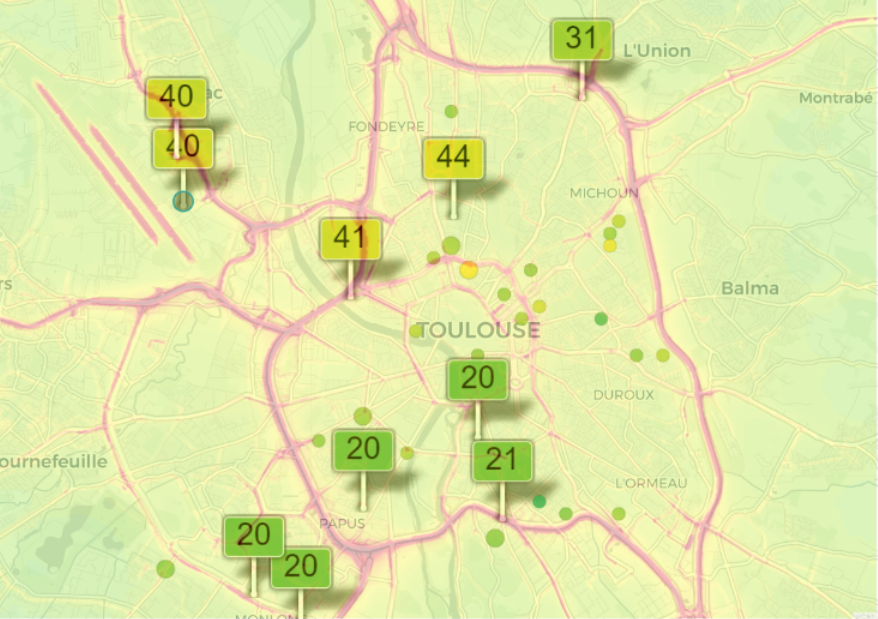

The map above is showing the quality air station locations and the areas the more polluted. We can see that it is link to the traffic zone. 

One of the most polluted area is the Périphérique. As the station "Port de l Embouchure Trafic" is the closest to one the highest traffic zone, we choose to base our study on this station.

In [ ]:
air_quality_port_embouchure = air_quality_toulouse[air_quality["nom_station"]=='Toulouse - Port de l Embouchure Trafic']

## Interval Date and Format

In [ ]:
air_quality_port_embouchure['date_debut'].sort_values()

26506    2019/12/18 00:00:00+00
26502    2019/12/18 00:00:00+00
26493    2019/12/18 00:00:00+00
25887    2019/12/18 00:00:00+00
30393    2019/12/19 00:00:00+00
                  ...          
16154    2020/12/14 00:00:00+00
17035    2020/12/15 00:00:00+00
17071    2020/12/15 00:00:00+00
17130    2020/12/15 00:00:00+00
17254    2020/12/15 00:00:00+00
Name: date_debut, Length: 1400, dtype: object

We only need the date without the hours and the time zone as there is no information.

In [ ]:
air_quality_port_embouchure_date = air_quality_port_embouchure
air_quality_port_embouchure_date['date_debut']
air_quality_port_embouchure_date['date_debut'] = pd.to_datetime(air_quality_port_embouchure['date_debut'].str.split(pat='+').str[0])
air_quality_port_embouchure_date['date_fin'] = pd.to_datetime(air_quality_port_embouchure['date_fin'].str.split(pat='+').str[0])

In [ ]:
air_quality_last_date = air_quality_port_embouchure_date['date_fin'].max()
air_quality_first_date = air_quality_port_embouchure_date['date_debut'].min()
print(air_quality_first_date, air_quality_last_date)
air_quality_port_embouchure_date['date'] = air_quality_port_embouchure['date_debut'].dt.date

2019-12-18 00:00:00 2020-12-15 23:59:00


In [ ]:
air_quality_port_embouchure_date['date']

69       2020-04-29
122      2020-02-19
123      2020-02-19
130      2020-02-19
132      2020-02-19
            ...    
49165    2020-12-01
49272    2020-12-02
49290    2020-12-02
49310    2020-12-02
49355    2020-12-02
Name: date, Length: 1400, dtype: object

# Meteo Station Choice


In [ ]:
code_stations = pd.read_csv('/content/drive/MyDrive/Data_Driven/Meteo/stations-meteo-en-place.csv',sep=";")

We used the air quality station on the coordinates x=1.41518 y=43.6103.

We must choose the meteo station the closest to that location.

In [ ]:
code_stations[code_stations["ville"]=="Toulouse"].sort_values("longitude")

,longitude,latitude,altitude,id_nom,id_numero,emission,installation,type_stati,lcz,ville,bati,veg_haute
62,1.373733,43.574416,157.60,01-station-meteo-toulouse-meteopole,1,V,2017-06-26,ISS,5,Toulouse,19290.4474,1489.9190
63,1.378182,43.589509,154.89,51-station-meteo-toulouse-lardenne,51,V,2019-02-07,ISS,6,Toulouse,40519.6967,17772.4366
43,1.385669,43.566433,157.20,08-station-meteo-toulouse-basso-cambo,8,V,2017-06-26,ISS,8,Toulouse,26469.3500,12992.0279
66,1.397601,43.607689,150.58,36-station-meteo-toulouse-purpan,36,V,2019-02-07,ISS,8,Toulouse,44154.6983,156.2942
44,1.398312,43.560598,146.90,26-station-meteo-toulouse-reynerie,26,V,2019-04-15,ISS,4,Toulouse,29055.0656,26860.0938
64,1.399230,43.585416,153.90,52-station-meteo-toulouse-cepiere,52,N,2019-02-07,ISS,5,Toulouse,26344.5143,12666.7057
17,1.403609,43.552818,147.90,40-station-meteo-toulouse-zi-thibaud,40,V,2019-04-15,ISS,8,Toulouse,58638.7097,6071.4005
70,1.406768,43.611215,131.41,41-station-meteo-toulouse-avenue-de-casselardit,41,V,2019-02-07,ISS,11,Toulouse,11002.3848,30064.3467
15,1.408942,43.587697,140.40,30-station-meteo-toulouse-george-sand,30,V,2020-12-10,ISS,6,Toulouse,NaN,NaN
67,1.416394,43.597441,139.35,07-station-meteo-toulouse-avenue-de-grande-bre...,7,V,2017-06-26,ISS,5,Toulouse,45678.5798,5189.4015


The meteo station the closest to the air quality station (1.41518 y=43.6103) is : 07-station-meteo-toulouse-avenue-de-grande-bretagne	

# Choice of polluant (PM10)

There are different polluant possible for the target of our model. In our case, we want to look at the pollution caused by the traffic. 

The two highest polluants caused by the traffic are the PM10 and the NO2.

We will make a first model based on the PM10.

In [ ]:
air_quality_port_embouchure_date_PM10 = air_quality_port_embouchure_date[air_quality_port_embouchure['nom_poll']== 'PM10']
air_quality_port_embouchure_date_PM10 = air_quality_port_embouchure_date_PM10.reset_index(drop =True)
air_quality_port_embouchure_date_PM10 = air_quality_port_embouchure_date_PM10.rename(columns={"valeur": "PM10_valeur"})

In [ ]:
air_quality_port_embouchure_date_PM10.head()

,X,Y,nom_dept,nom_com,insee_com,nom_station,code_station,typologie,influence,nom_poll,id_poll_ue,PM10_valeur,unite,metrique,date_debut,date_fin,statut_valid,x_l93,y_l93,ObjectId,date
0,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,PM10,5,10.1,ug.m-3,journaliere,2020-04-29,2020-04-29 23:59:00,t,572027,6280312,70,2020-04-29
1,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,PM10,5,25.6,ug.m-3,journaliere,2020-02-19,2020-02-19 23:59:00,t,572027,6280312,131,2020-02-19
2,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,PM10,5,16.8,ug.m-3,journaliere,2019-12-28,2019-12-28 23:59:00,t,572027,6280312,198,2019-12-28
3,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,PM10,5,13.8,ug.m-3,journaliere,2020-04-09,2020-04-09 23:59:00,t,572027,6280312,247,2020-04-09
4,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,PM10,5,17.4,ug.m-3,journaliere,2019-12-29,2019-12-29 23:59:00,t,572027,6280312,444,2019-12-29


# Meteo

In [ ]:
meteo = pd.read_csv('/content/drive/MyDrive/Data_Driven/Meteo/07-station-meteo-toulouse-avenue-de-grande-bretagne.csv',sep=';')

## Date interval and Format

In [ ]:
print('first date : ',meteo['heure_de_paris'].min())
print('last date : ',meteo['heure_de_paris'].max())

first date :  2019-06-21T02:00:00+02:00
last date :  2020-12-16T14:15:00+01:00


### Clean the date (remove string character)

In [ ]:
meteo['heure_de_paris'] = meteo['heure_de_paris'].str.split(pat='+').str[0].str.replace('T',' ')
meteo['heure_de_paris']

0        2020-07-10 16:00:00
1        2020-06-10 07:00:00
2        2020-06-08 21:30:00
3        2020-06-08 20:45:00
4        2020-06-08 21:15:00
                ...         
51624    2020-12-16 06:15:00
51625    2020-12-16 07:15:00
51626    2020-12-16 08:00:00
51627    2020-12-16 08:30:00
51628    2020-12-16 11:45:00
Name: heure_de_paris, Length: 51629, dtype: object

### Convert to datetime

In [ ]:
meteo['heure_de_paris'] = pd.to_datetime(meteo['heure_de_paris'])
meteo['heure_de_paris']

0       2020-07-10 16:00:00
1       2020-06-10 07:00:00
2       2020-06-08 21:30:00
3       2020-06-08 20:45:00
4       2020-06-08 21:15:00
                ...        
51624   2020-12-16 06:15:00
51625   2020-12-16 07:15:00
51626   2020-12-16 08:00:00
51627   2020-12-16 08:30:00
51628   2020-12-16 11:45:00
Name: heure_de_paris, Length: 51629, dtype: datetime64[ns]

### Creation of date only column


In [ ]:
meteo['date'] = meteo['heure_de_paris'].dt.date
meteo['date']

0        2020-07-10
1        2020-06-10
2        2020-06-08
3        2020-06-08
4        2020-06-08
            ...    
51624    2020-12-16
51625    2020-12-16
51626    2020-12-16
51627    2020-12-16
51628    2020-12-16
Name: date, Length: 51629, dtype: object

### Select the interval date according to the air quality first and last date

In [ ]:
mask = (meteo['heure_de_paris'] <= air_quality_last_date) & (meteo['heure_de_paris'] >= air_quality_first_date)
meteo_date = meteo[mask]
meteo_date['date'].sort_values()

1781     2019-12-18
19388    2019-12-18
34528    2019-12-18
34530    2019-12-18
34532    2019-12-18
            ...    
50954    2020-12-15
51526    2020-12-15
51525    2020-12-15
51406    2020-12-15
51615    2020-12-15
Name: date, Length: 34373, dtype: object

### Drop meaningless columns

In [ ]:
meteo_date.describe()

,id,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_vent_moyen,pluie,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature
count,34373.0,34373.000000,34373.000000,34373.000000,34373.000000,34373.0,34373.0,34373.000000,34373.000000,34373.000000,34373.000000
mean,7.0,73.403922,7.910569,0.006267,100017.921043,0.0,0.0,177.987810,4.128444,11.634393,15.730652
std,0.0,16.165162,4.065596,0.036155,918.982429,0.0,0.0,91.475899,3.720987,9.568359,6.959192
min,7.0,0.000000,0.000000,0.000000,90000.000000,0.0,0.0,0.000000,0.000000,0.000000,-50.000000
25%,7.0,64.000000,10.000000,0.000000,99600.000000,0.0,0.0,225.000000,1.000000,5.000000,10.600000
50%,7.0,78.000000,10.000000,0.000000,100000.000000,0.0,0.0,225.000000,4.000000,10.000000,14.900000
75%,7.0,86.000000,10.000000,0.000000,100500.000000,0.0,0.0,225.000000,6.000000,18.000000,20.300000
max,7.0,97.000000,10.000000,0.800000,101900.000000,0.0,0.0,225.000000,29.000000,66.000000,37.800000


There is multiple columns where there is no information. We can drop them.

In [ ]:
meteo_date_filter = meteo_date.drop(columns=["direction_du_vecteur_vent_moyen","pluie"],axis=1)

### Groupby date

In [ ]:
groupby_dict = {"humidite":"mean",
                "direction_du_vecteur_de_vent_max":"mean",
                "pluie_intensite_max":"mean",
                "pression":"mean",
                "direction_du_vecteur_de_rafale_de_vent_max":"mean",
                "force_moyenne_du_vecteur_vent":"mean",
                "force_rafale_max":"mean",
                "temperature":"mean"}

In [ ]:
meteo_groupby_date = meteo_date_filter.groupby(['date']).agg(groupby_dict)
meteo_groupby_date

,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature
date,,,,,,,,
2019-12-18,84.484211,7.052632,0.000000,99547.368421,158.684211,5.652632,15.189474,13.422105
2019-12-19,76.802083,10.000000,0.000000,98864.583333,225.000000,13.937500,35.468750,14.503125
2019-12-20,77.968421,9.894737,0.000000,97785.263158,222.631579,7.726316,20.621053,12.641053
2019-12-21,83.494737,9.789474,0.000000,97904.210526,220.263158,5.042105,14.768421,11.002105
2019-12-22,81.906250,9.583333,0.000000,98772.916667,215.625000,10.208333,25.812500,10.757292
...,...,...,...,...,...,...,...,...
2020-12-11,90.510417,10.000000,0.089583,98428.125000,225.000000,5.916667,16.000000,10.019792
2020-12-12,86.020833,10.000000,0.070833,99101.041667,225.000000,7.875000,20.375000,9.656250
2020-12-13,86.781250,7.604167,0.002083,99585.416667,171.093750,1.885417,5.760417,8.885417


# Join Meteo and Air Quality data / Feature Selection

In [ ]:
meteo_air_join = air_quality_port_embouchure_date_PM10.set_index('date').join(meteo_groupby_date)

In [ ]:
is_NaN = meteo_air_join.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = meteo_air_join[row_has_NaN]
print("Number of NaN rows:" ,len(rows_with_NaN))

Number of NaN rows: 4


We will remove this 4 rows as they may false our model.

In [ ]:
meteo_air_join_no_na = meteo_air_join.dropna(axis='rows')

In [ ]:
usefull_col = ['PM10_valeur', 'humidite',
       'direction_du_vecteur_de_vent_max', 'pluie_intensite_max', 'pression',
       'direction_du_vecteur_de_rafale_de_vent_max',
       'force_moyenne_du_vecteur_vent', 'force_rafale_max', 'temperature']
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na[usefull_col]

In [ ]:
meteo_air_join_no_na_usefull_col.describe()

,PM10_valeur,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,20.233521,73.694606,7.915340,0.006533,100012.562934,178.095160,4.145780,11.678155,15.612327
std,8.827700,11.533649,2.114178,0.017841,804.572292,47.568996,2.640827,6.848680,6.176817
min,5.200000,36.177083,1.354167,0.000000,95490.909091,30.468750,0.156250,0.864583,2.534375
25%,14.500000,65.421875,6.562500,0.000000,99623.437500,147.656250,2.239583,6.750000,10.764583
50%,18.400000,76.354167,8.541667,0.000000,100019.791667,192.187500,3.541667,10.416667,14.933333
75%,25.050000,82.738487,9.791667,0.002083,100504.687500,220.312500,5.692708,15.682292,20.667708
max,58.500000,92.336842,10.000000,0.106250,101737.500000,225.000000,15.052083,39.364583,29.676042


### Show correlation between the target (PM10_value) and the others features

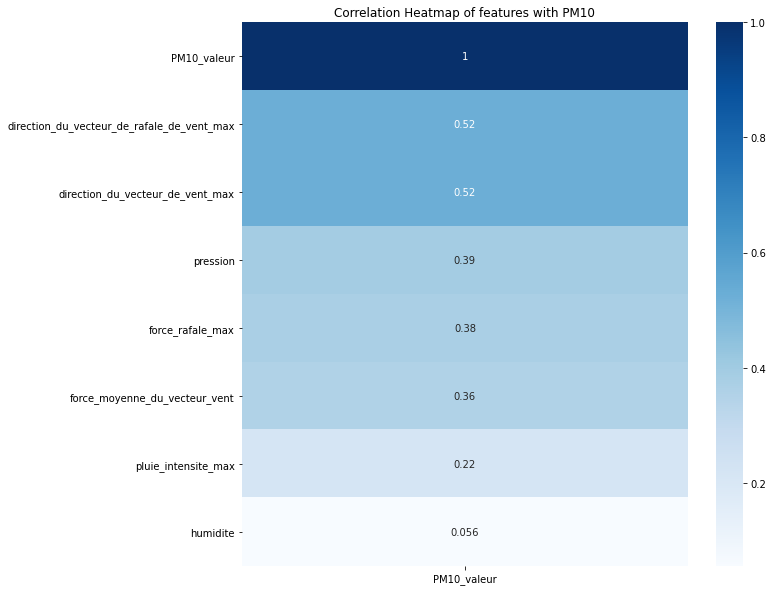

In [ ]:
corr = meteo_air_join_no_na_usefull_col.corr()
corr_PM10 = corr[['PM10_valeur']][:-1].abs().sort_values(['PM10_valeur'], ascending=[0])

fig, ax = plt.subplots(figsize=(10,10)) 
heat_map_corr = sns.heatmap(corr_PM10, annot=True, cmap='Blues')
heat_map_corr = heat_map_corr.set_title('Correlation Heatmap of features with PM10')

We can see that the two columns on the wind have the same correlation with PM10_value. We will remove one of them.

In [ ]:
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na_usefull_col.drop(columns=['direction_du_vecteur_de_rafale_de_vent_max'])

### Show correlation between each feature between each others

In [ ]:
corr_high_features = meteo_air_join_no_na_usefull_col.corr()

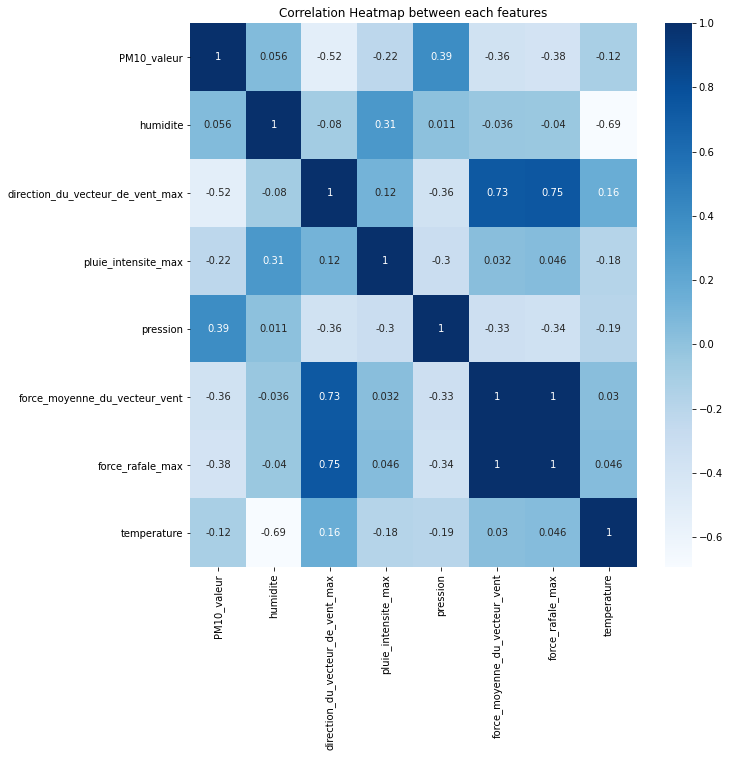

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
x = sns.heatmap(corr_high_features, annot=True, cmap='Blues')
x = x.set_title('Correlation Heatmap between each features')

In this matrix, we can see that force_moyenne_du_vecteur_max evolve in the same way that force_rafale_max. 

Therefore, we will drop the feature having the little correlation with the PM10 (force_moyenne_du_vecteur_vent with -0.356648).

In [ ]:
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na_usefull_col.drop(columns=['force_moyenne_du_vecteur_vent'])

Show variance for each feature

In [ ]:
meteo_air_join_no_na_usefull_col.var()

PM10_valeur                             77.928280
humidite                               133.025070
direction_du_vecteur_de_vent_max         4.469747
pluie_intensite_max                      0.000318
pression                            647336.572817
force_rafale_max                        46.904422
temperature                             38.153067
dtype: float64

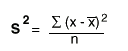

The variance indicates how each variable is likely to change. 

Each variable have its own tendancy to change and we can not exclude any of our feature.

In [ ]:
meteo_air_clean = meteo_air_join_no_na_usefull_col

# Choice of polluant (PM10)

The two highest polluants caused by the traffic are the PM10 and the NO2.

We will make a second model based on the NO2.

In [ ]:
air_quality_port_embouchure_date_NO2 = air_quality_port_embouchure_date[air_quality_port_embouchure['nom_poll']== 'NO2']
air_quality_port_embouchure_date_NO2 = air_quality_port_embouchure_date_NO2.reset_index(drop =True)
air_quality_port_embouchure_date_NO2 = air_quality_port_embouchure_date_NO2.rename(columns={"valeur": "NO2_valeur"})

In [ ]:
air_quality_port_embouchure_date_NO2.head()

,X,Y,nom_dept,nom_com,insee_com,nom_station,code_station,typologie,influence,nom_poll,id_poll_ue,NO2_valeur,unite,metrique,date_debut,date_fin,statut_valid,x_l93,y_l93,ObjectId,date
0,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,NO2,8,62.5,ug.m-3,journaliere,2020-02-19,2020-02-19 23:59:00,t,572027,6280312,124,2020-02-19
1,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,NO2,8,55.0,ug.m-3,journaliere,2019-12-28,2019-12-28 23:59:00,t,572027,6280312,210,2019-12-28
2,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,NO2,8,23.3,ug.m-3,journaliere,2019-12-29,2019-12-29 23:59:00,t,572027,6280312,436,2019-12-29
3,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,NO2,8,38.6,ug.m-3,journaliere,2019-12-30,2019-12-30 23:59:00,t,572027,6280312,644,2019-12-30
4,1.41518,43.6103,HAUTE-GARONNE,TOULOUSE,31555,Toulouse - Port de l Embouchure Trafic,FR50821,Urbaine,Trafic,NO2,8,24.7,ug.m-3,journaliere,2020-04-29,2020-04-29 23:59:00,t,572027,6280312,696,2020-04-29


# Prediction of the Air Quality (PM10)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import numpy as np

Extract features

In [ ]:
meteo_air_clean_features = meteo_air_clean.loc[:,meteo_air_clean.columns!="PM10_valeur" ]

Extract target

In [ ]:
target = meteo_air_clean['PM10_valeur']

## Standardisation of the data

Standardisation is crucial for a model. The model will be faster using values between -1 and 1.

In [ ]:
scaler = StandardScaler()
scalerized_features = scaler.fit_transform(meteo_air_clean_features)
meteo_air_scalered_features = pd.DataFrame(
    scalerized_features, columns=meteo_air_clean_features.columns
)

## Train_Test Split

Split the the dataset into 2 subsets train and test. 

We could split the dataset into two periods of time of the year. The risk of doing so is that we train our model on seasonality. For example, as Toulouse is in the south, the traffic during summer may be higher. If the model train itself based on this specific time, the model will be biased on another period of time.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(meteo_air_scalered_features, target, test_size=0.20, random_state=42)

## Linear Regression

Create linearRegression object and train on X_train

In [ ]:
reg_LR_PM10 = LinearRegression().fit(X_train, y_train)

In [ ]:
predict_PM10_LR = reg_LR_PM10.predict(X_test)

df_predict = pd.DataFrame({
    'predict_PM10_LR': predict_PM10_LR,
    'True_PM10': y_test,
    'Diff_percentage':np.round((predict_PM10_LR-y_test)/y_test*100,1)
})

df_predict.head()

,predict_PM10_LR,True_PM10,Diff_percentage
date,,,
2020-04-22,19.254987,8.0,140.7
2020-01-23,18.308397,25.4,-27.9
2020-04-01,16.813578,16.8,0.1
2019-12-18,21.634742,27.3,-20.8
2020-03-05,15.338248,11.4,34.5


In [ ]:
mean_diff_percentage_PM10_LR = df_predict['Diff_percentage'].mean()
mean_diff_percentage_PM10_LR

15.723943661971832

Plot the predict and the true PM10

In [ ]:
df_predict_sort_index = df_predict.sort_index()

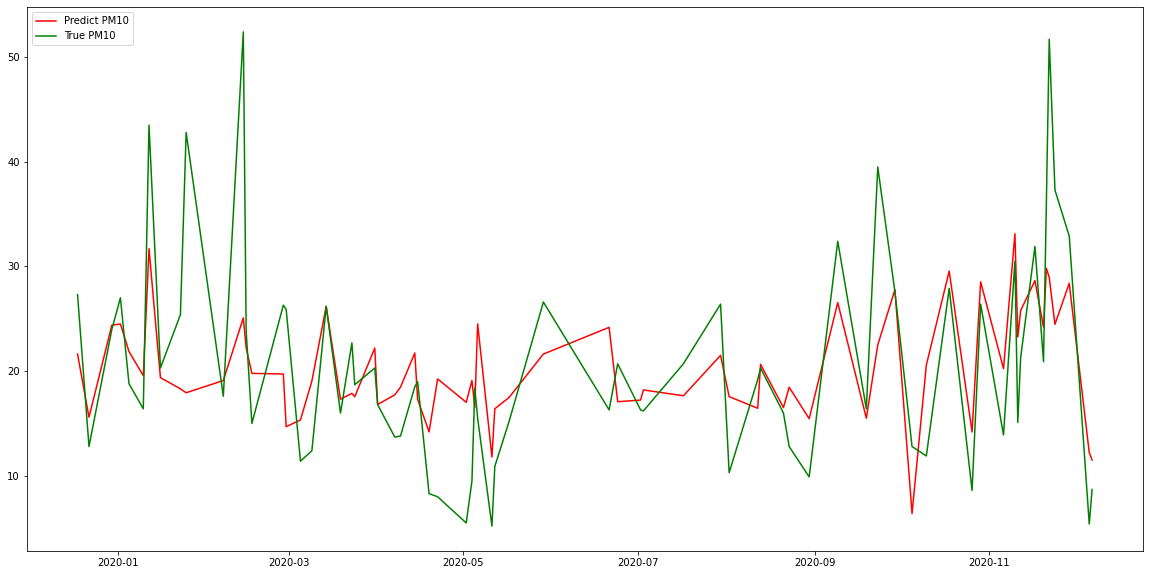

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
x = df_predict_sort_index.index

ax.plot(x, df_predict_sort_index["predict_PM10_LR"], c = 'red', label='Predict PM10')
ax.plot(x, df_predict_sort_index["True_PM10"], c='green', label='True PM10')

plt.legend()

Display the R² score

In [ ]:
score_test_PM10_LR = reg_LR_PM10.score(X_test, y_test)
print("R² test score=",score_test_PM10_LR)
score_train_PM10_LR = reg_LR_PM10.score(X_train, y_train)
print("R² train score =",score_train_PM10_LR)

R² test score= 0.43203987045076286
R² train score = 0.2959754463598513


Mean Square Error(MSE)/Root Mean Square Error(RMSE)

In [ ]:
MSE_PM10_LR = mean_squared_error(y_test, predict_PM10_LR)
print("Mean Square Error(MSE) =" , mean_squared_error(y_test, predict_PM10_LR))
print("Root Mean Square Error(RMSE) =", math.sqrt(mean_squared_error(y_test, predict_PM10_LR)))

Mean Square Error(MSE) = 59.15534704943543
Root Mean Square Error(RMSE) = 7.691251331833815


In [ ]:
feature_coef_PM10_LR = pd.DataFrame(reg_LR_PM10.coef_, columns=["Influence of the feature on the model"],index=meteo_air_clean_features.columns).abs().sort_values(by=["Influence of the feature on the model"],ascending=False)

In [ ]:
feature_coef_PM10_LR

,Influence of the feature on the model
direction_du_vecteur_de_vent_max,3.868128
pression,2.132575
humidite,0.773033
force_rafale_max,0.711926
pluie_intensite_max,0.691937
temperature,0.636639


The two features influencing the most our model are the "direction_du_vecteur_de_vent_max" and the "pression".

We can think of including the influence of the period of the year to the model. 

The problem here is that we only have one year of data. Therefore, we can not take in count this parameter.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg_RF_PM10 = RandomForestRegressor()
reg_RF_PM10.fit(X_train, y_train)
predict_PM10_RF = reg_RF_PM10.predict(X_test)

In [ ]:
df_predict = pd.DataFrame({
    'predict_PM10_RF': predict_PM10_RF,
    'True_PM10': y_test,
    'Diff_percentage':np.round((predict_PM10_RF-y_test)/y_test*100,1)
})

df_predict.head()

,predict_PM10_RF,True_PM10,Diff_percentage
date,,,
2020-04-22,21.754,8.0,171.9
2020-01-23,16.866,25.4,-33.6
2020-04-01,16.528,16.8,-1.6
2019-12-18,17.829,27.3,-34.7
2020-03-05,12.793,11.4,12.2


In [ ]:
mean_diff_percentage_PM10_RF = df_predict['Diff_percentage'].mean()
mean_diff_percentage_PM10_RF

14.25774647887324

Plot the predict and the true PM10

In [ ]:
df_predict_sort_index = df_predict.sort_index()

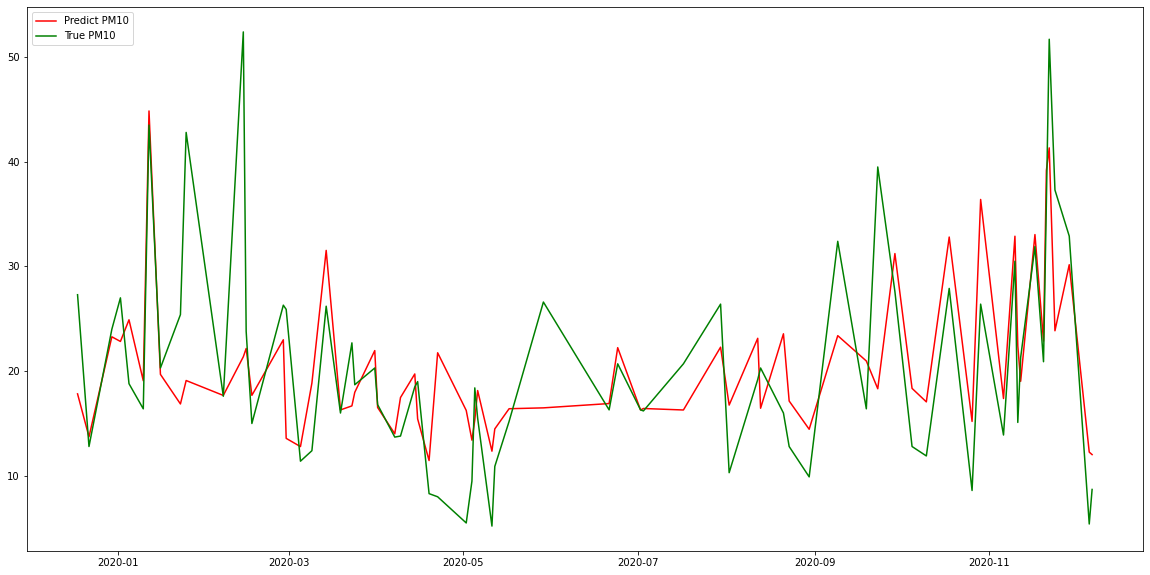

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
x = df_predict_sort_index.index

ax.plot(x, df_predict_sort_index["predict_PM10_RF"], c = 'red', label='Predict PM10')
ax.plot(x, df_predict_sort_index["True_PM10"], c='green', label='True PM10')

plt.legend()

Display the R² score

In [ ]:
score_test_PM10_RF = reg_RF_PM10.score(X_test, y_test)
print("R² test score=",score_test_PM10_RF)
score_train_PM10_RF = reg_RF_PM10.score(X_train, y_train)
print("R² train score =",score_train_PM10_RF)

R² test score= 0.4562923628300257
R² train score = 0.9106313170639272


With the random forest, we obtain a bigger score on the train set than the linear regression.

Mean Square Error(MSE)/Root Mean Square Error(RMSE)

In [ ]:
MSE_PM10_RF = mean_squared_error(y_test, predict_PM10_RF)
print("Mean Square Error(MSE) =" , mean_squared_error(y_test, predict_PM10_RF))
print("Root Mean Square Error(RMSE) =", math.sqrt(mean_squared_error(y_test, predict_PM10_RF)))

Mean Square Error(MSE) = 56.6293517746479
Root Mean Square Error(RMSE) = 7.5252476221482505


In [ ]:
feature_coef_PM10_RF = pd.DataFrame(reg_RF_PM10.feature_importances_, columns=["Influence of the feature on the model"],index=meteo_air_clean_features.columns).abs().sort_values(by=["Influence of the feature on the model"],ascending=False)

In [ ]:
feature_coef_PM10_RF

,Influence of the feature on the model
force_rafale_max,0.382794
temperature,0.207554
pression,0.160665
direction_du_vecteur_de_vent_max,0.115118
humidite,0.100036
pluie_intensite_max,0.033833


With the Random Forest, the features with the highest influence are the "force_rafale_max" and the "temperature"

# Join Meteo and Air Quality / Feature Selection

In [ ]:
meteo_air_join = air_quality_port_embouchure_date_NO2.set_index('date').join(meteo_groupby_date)

In [ ]:
is_NaN = meteo_air_join.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = meteo_air_join[row_has_NaN]
print("Number of NaN rows:" ,len(rows_with_NaN))

Number of NaN rows: 4


We will remove this 4 rows as they may false our model.

In [ ]:
meteo_air_join_no_na = meteo_air_join.dropna(axis='rows')

In [ ]:
usefull_col = ['NO2_valeur', 'humidite',
       'direction_du_vecteur_de_vent_max', 'pluie_intensite_max', 'pression',
       'direction_du_vecteur_de_rafale_de_vent_max',
       'force_moyenne_du_vecteur_vent', 'force_rafale_max', 'temperature']
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na[usefull_col]

In [ ]:
meteo_air_join_no_na_usefull_col.describe()

,NO2_valeur,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,34.962974,73.254834,7.917420,0.006391,99998.549708,178.141948,4.126646,11.630513,15.717386
std,16.639871,11.635653,2.095518,0.017659,806.624997,47.149165,2.589347,6.722407,6.297486
min,2.300000,36.177083,1.354167,0.000000,95490.909091,30.468750,0.156250,0.864583,2.534375
25%,22.850000,65.052083,6.562500,0.000000,99610.416667,147.656250,2.222064,6.750000,10.734468
50%,36.000000,75.697917,8.541667,0.000000,100003.125000,192.187500,3.541667,10.541667,15.141667
75%,47.900000,82.583666,9.791667,0.002083,100491.666667,220.312500,5.713542,15.653759,21.018750
max,77.700000,92.336842,10.000000,0.106250,101737.500000,225.000000,15.052083,39.364583,29.676042


### Show correlation between the target (NO2_value) and the others features

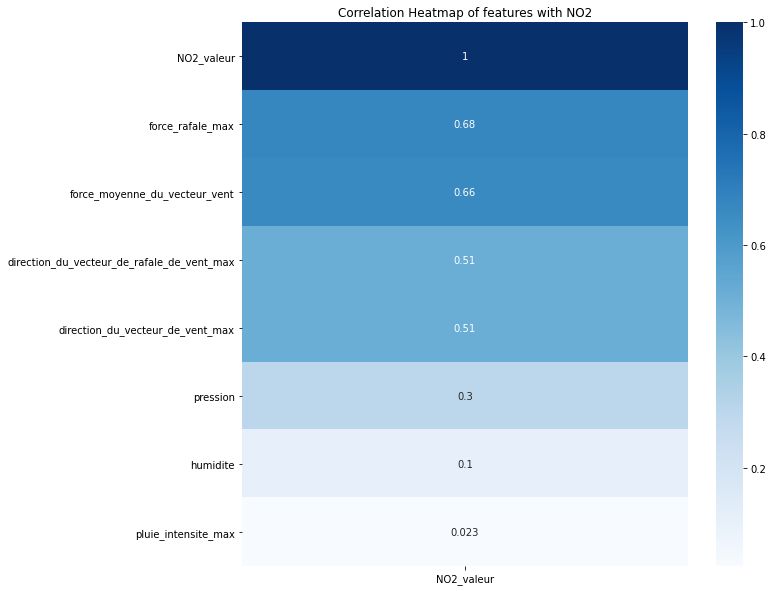

In [ ]:
corr = meteo_air_join_no_na_usefull_col.corr()
corr_NO2 = corr[['NO2_valeur']][:-1].abs().sort_values(['NO2_valeur'], ascending=[0])

fig, ax = plt.subplots(figsize=(10,10)) 
heat_map_corr = sns.heatmap(corr_NO2, annot=True, cmap='Blues')
heat_map_corr = heat_map_corr.set_title('Correlation Heatmap of features with NO2')

We can see that the two columns on the wind have the same correlation with PM10_value. We will remove one of them.

In [ ]:
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na_usefull_col.drop(columns=['direction_du_vecteur_de_rafale_de_vent_max'])

### Show correlation between each feature between each others

In [ ]:
corr_high_features = meteo_air_join_no_na_usefull_col.corr()

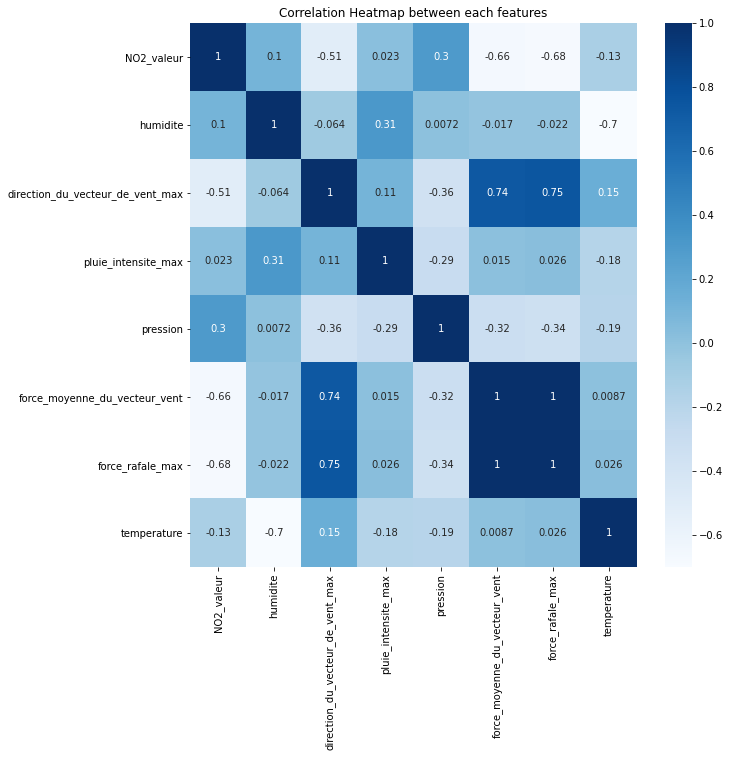

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
x = sns.heatmap(corr_high_features, annot=True, cmap='Blues')
x = x.set_title('Correlation Heatmap between each features')

In this matrix, we can see that force_moyenne_du_vecteur_max evolve in the same way that force_rafale_max. 

Therefore, we will drop the feature having the little correlation with the NO2 (force_moyenne_du_vecteur_vent with 0.66).

In [ ]:
meteo_air_join_no_na_usefull_col = meteo_air_join_no_na_usefull_col.drop(columns=['force_moyenne_du_vecteur_vent'])

In [ ]:
meteo_air_clean = meteo_air_join_no_na_usefull_col

# Prediction of the Air Quality (NO2)

Extract features

In [ ]:
meteo_air_clean_features = meteo_air_clean.loc[:,meteo_air_clean.columns!="NO2_valeur" ]

Extract target

In [ ]:
target = meteo_air_clean['NO2_valeur']

## Standardisation of the data

Standardisation is crucial for a model. The model will be faster using values between -1 and 1.

In [ ]:
scaler = StandardScaler()
scalerized_features = scaler.fit_transform(meteo_air_clean_features)
meteo_air_scalered_features = pd.DataFrame(
    scalerized_features, columns=meteo_air_clean_features.columns
)

## Train_Test Split

Split the the dataset into 2 subsets train and test. 

We could split the dataset into two periods of time of the year. The risk of doing so is that we train our model on seasonality. For example, as Toulouse is in the south, the traffic during summer may be higher. If the model train itself based on this specific time, the model will be biased on another period of time.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(meteo_air_scalered_features, target, test_size=0.20, random_state=42)

## Linear Regression

Create linearRegression object and train on X_train

In [ ]:
reg_LR_NO2 = LinearRegression().fit(X_train, y_train)

In [ ]:
predict_NO2_LR = reg_LR_NO2.predict(X_test)

df_predict = pd.DataFrame({
    'predict_NO2_LR': predict_NO2_LR,
    'True_NO2': y_test,
    'Diff_percentage':np.round((predict_NO2_LR-y_test)/y_test*100,1)
})

df_predict.head()

,predict_NO2_LR,True_NO2,Diff_percentage
date,,,
2020-02-14,44.196105,77.7,-43.1
2020-05-10,22.804853,10.8,111.2
2020-06-28,33.507210,28.7,16.7
2020-01-23,29.747534,22.5,32.2
2020-09-13,37.280591,17.7,110.6


In [ ]:
mean_diff_percentage_NO2_LR = df_predict['Diff_percentage'].mean()
mean_diff_percentage_NO2_LR

7.191304347826088

Plot the predict and the true NO2

In [ ]:
df_predict_sort_index = df_predict.sort_index()

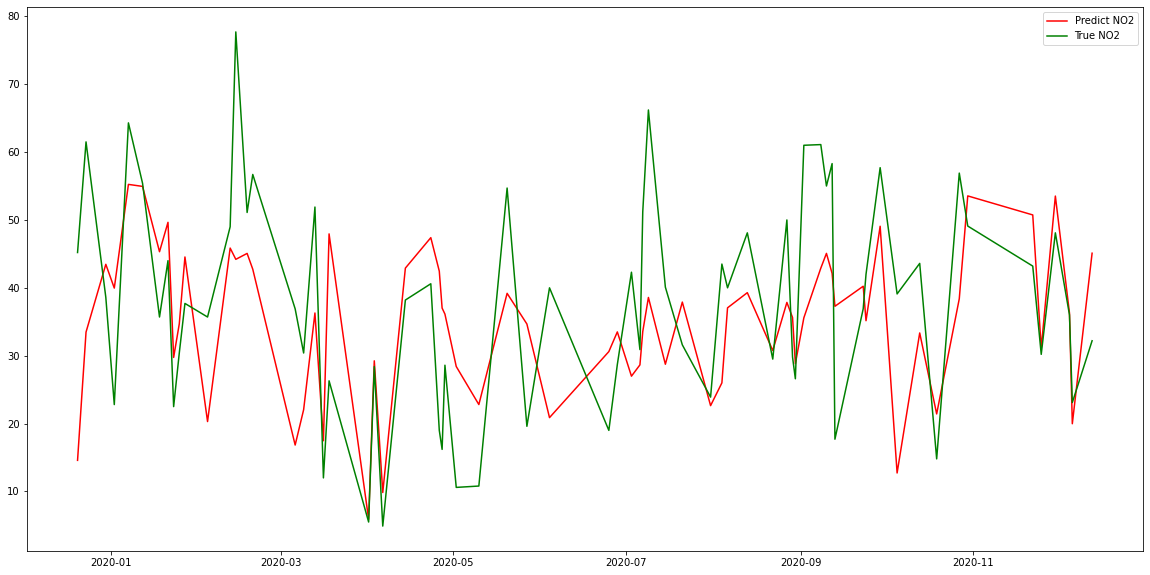

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
x = df_predict_sort_index.index

ax.plot(x, df_predict_sort_index["predict_NO2_LR"], c = 'red', label='Predict NO2')
ax.plot(x, df_predict_sort_index["True_NO2"], c='green', label='True NO2')

plt.legend()

Display the R² score

In [ ]:
score_test_NO2_LR = reg_LR_NO2.score(X_test, y_test)
print("R² test score=",score_test_NO2_LR)
score_train_NO2_LR = reg_LR_NO2.score(X_train, y_train)
print("R² train score =",score_train_NO2_LR)

R² test score= 0.23091974173948404
R² train score = 0.5178086839324572


Mean Square Error(MSE)/Root Mean Square Error(RMSE)

In [ ]:
MSE_NO2_LR = mean_squared_error(y_test, predict_NO2_LR)
print("Mean Square Error(MSE) =" , mean_squared_error(y_test, predict_NO2_LR))
print("Root Mean Square Error(RMSE) =", math.sqrt(mean_squared_error(y_test, predict_NO2_LR)))

Mean Square Error(MSE) = 190.65595555580734
Root Mean Square Error(RMSE) = 13.807822259712331


In [ ]:
feature_coef_NO2_LR = pd.DataFrame(reg_LR_NO2.coef_, columns=["Influence of the feature on the model"],index=meteo_air_clean_features.columns).abs().sort_values(by=["Influence of the feature on the model"],ascending=False)

In [ ]:
feature_coef_NO2_LR

,Influence of the feature on the model
force_rafale_max,11.180587
pression,2.144176
humidite,1.738131
pluie_intensite_max,1.000030
direction_du_vecteur_de_vent_max,0.585176
temperature,0.293320


The feature influencing the most our model is the "force_rafale_max".

We can think of including the influence of the period of the year to the model. 

The problem here is that we only have one year of data. Therefore, we can not take in count this parameter.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg_RF_NO2 = RandomForestRegressor()
reg_RF_NO2.fit(X_train, y_train)
predict_NO2_RF = reg_RF_NO2.predict(X_test)

In [ ]:
df_predict = pd.DataFrame({
    'predict_NO2_RF': predict_NO2_RF,
    'True_NO2': y_test,
    'Diff_percentage':np.round((predict_NO2_RF-y_test)/y_test*100,1)
})

df_predict.head()

,predict_NO2_RF,True_NO2,Diff_percentage
date,,,
2020-02-14,36.576,77.7,-52.9
2020-05-10,23.537,10.8,117.9
2020-06-28,39.897,28.7,39.0
2020-01-23,27.543,22.5,22.4
2020-09-13,38.200,17.7,115.8


In [ ]:
mean_diff_percentage_NO2_RF = df_predict['Diff_percentage'].mean()
mean_diff_percentage_NO2_RF

8.176811594202901

Plot the predict and the true NO2

In [ ]:
df_predict_sort_index = df_predict.sort_index()

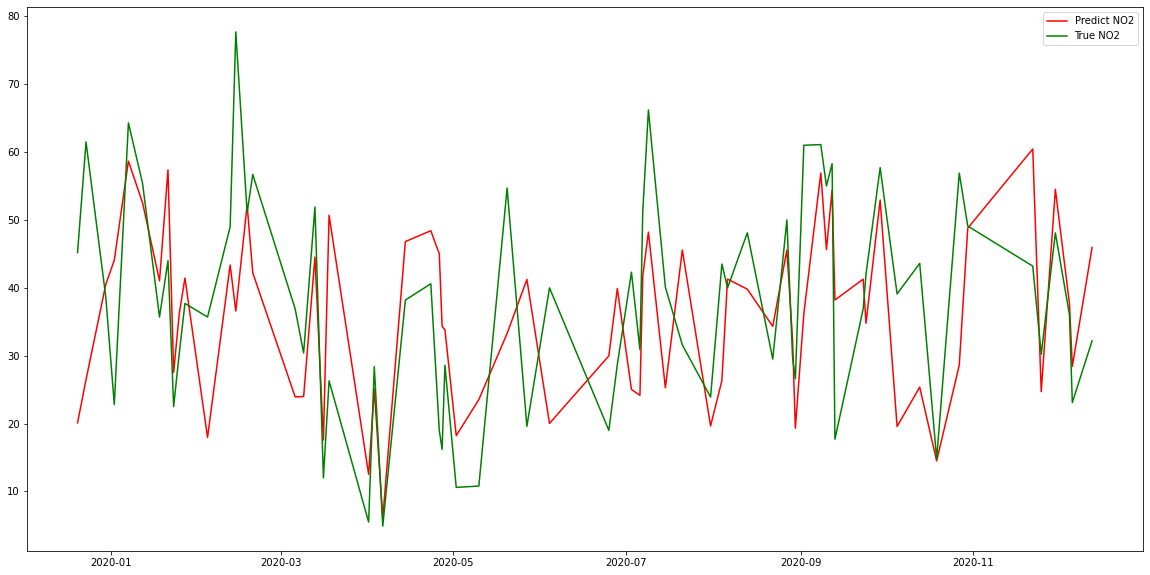

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
x = df_predict_sort_index.index

ax.plot(x, df_predict_sort_index["predict_NO2_RF"], c = 'red', label='Predict NO2')
ax.plot(x, df_predict_sort_index["True_NO2"], c='green', label='True NO2')

plt.legend()

Display the R² score

In [ ]:
score_test_NO2_RF = reg_RF_NO2.score(X_test, y_test)
print("R² test score=",score_test_NO2_RF)
score_train_NO2_RF = reg_RF_NO2.score(X_train, y_train)
print("R² train score =",score_train_NO2_RF)

R² test score= 0.19302223981498834
R² train score = 0.9346327683982353


With the random forest, we obtain a bigger score on the train set than the linear regression.

Mean Square Error(MSE)/Root Mean Square Error(RMSE)

In [ ]:
MSE_NO2_RF = mean_squared_error(y_test, predict_NO2_RF)
print("Mean Square Error(MSE) =" , mean_squared_error(y_test, predict_NO2_RF))
print("Root Mean Square Error(RMSE) =", math.sqrt(mean_squared_error(y_test, predict_NO2_RF)))

Mean Square Error(MSE) = 200.05079356521733
Root Mean Square Error(RMSE) = 14.143931333445357


In [ ]:
feature_coef_NO2_RF = pd.DataFrame(reg_RF_NO2.feature_importances_, columns=["Influence of the feature on the model"],index=meteo_air_clean_features.columns).abs().sort_values(by=["Influence of the feature on the model"],ascending=False)

In [ ]:
feature_coef_NO2_RF

,Influence of the feature on the model
force_rafale_max,0.611806
temperature,0.110392
pression,0.107249
humidite,0.091297
direction_du_vecteur_de_vent_max,0.055106
pluie_intensite_max,0.024151


With the Random Forest, the feature with the highest influence is the "force_rafale_max".

# Final Analysis

In [ ]:
feature_coef_PM10_LR.iloc[0].values

array([3.86812761])

In [ ]:
score_diff = np.array([mean_diff_percentage_PM10_LR, mean_diff_percentage_PM10_RF, mean_diff_percentage_NO2_LR, mean_diff_percentage_NO2_RF]).round(3)

score_r2_test = np.array([score_test_PM10_LR, score_test_PM10_RF, score_test_NO2_LR, 
            score_test_NO2_RF]).round(3) * 100
score_r2_train = np.array([score_train_PM10_LR, score_train_PM10_RF, score_train_NO2_LR, 
            score_train_NO2_RF]).round(3) * 100

score_MSE = np.array([MSE_PM10_LR, MSE_PM10_RF, MSE_NO2_LR, 
            MSE_NO2_RF]).round(3)


feature_coef_1 = np.array(['{} = {}'.format(feature_coef_PM10_LR.index[0],feature_coef_PM10_LR.iloc[0].values),
                        '{} = {}'.format(feature_coef_PM10_RF.index[0],feature_coef_PM10_RF.iloc[0].values),
                        '{} = {}'.format(feature_coef_NO2_LR.index[0],feature_coef_NO2_LR.iloc[0].values),
                        '{} = {}'.format(feature_coef_NO2_RF.index[0],feature_coef_NO2_RF.iloc[0].values)])

feature_coef_2 = np.array(['{} = {}'.format(feature_coef_PM10_LR.index[1],feature_coef_PM10_LR.iloc[1].values),
                        '{} = {}'.format(feature_coef_PM10_RF.index[1],feature_coef_PM10_RF.iloc[1].values),
                        '{} = {}'.format(feature_coef_NO2_LR.index[1],feature_coef_NO2_LR.iloc[1].values),
                        '{} = {}'.format(feature_coef_NO2_RF.index[1],feature_coef_NO2_RF.iloc[1].values)])



index_name = ['PM10 Linear Regression', 'PM10 Random Forest',
         'NO2 Linear Regression', 'NO2 Random Forest']

df_compare_metrics = pd.DataFrame({'Mean Difference Percentage':score_diff,
                                   'Score R² train (%)':score_r2_train,
                                   'Score R² test (%)':score_r2_test,
                                   'Score MSE':score_MSE,
                                   'Feature Coeff 1':feature_coef_1,
                                   'Feature Coeff 2':feature_coef_2
                                   
                                }, index = index_name)
df_compare_metrics

,Mean Difference Percentage,Score R² train (%),Score R² test (%),Score MSE,Feature Coeff 1,Feature Coeff 2
PM10 Linear Regression,15.724,29.6,43.2,59.155,direction_du_vecteur_de_vent_max = [3.86812761],pression = [2.1325748]
PM10 Random Forest,14.258,91.1,45.6,56.629,force_rafale_max = [0.38279405],temperature = [0.20755423]
NO2 Linear Regression,7.191,51.8,23.1,190.656,force_rafale_max = [11.18058717],pression = [2.14417565]
NO2 Random Forest,8.177,93.5,19.3,200.051,force_rafale_max = [0.61180575],temperature = [0.11039236]


* For the PM10 prediction, the R² score on the test set is 43 for the LR and 45 for the RF.
* For the NO2 prediction, the R² score on the test set is 23 for the LR and 20 for the RF.

Based on our results, we can conclude that the polluant NO2 is more hard to predict. 

We can also conclude that the Random Forest is more performant than the Linear Regressor.

The features having the biggest impact in the model are the "force_rafale_max"/ "direction_de_vent_max" and the pression.

# Trafic

As we chose the location of the air quality station based on the busiest area, the obvioulsy parameter to take in count would be the traffic. 

Unfortunately, the only source of data that we have is not relevant at all.

In [ ]:
trafic = pd.read_csv('/content/drive/MyDrive/Data_Driven/Trafic/comptages-routiers.csv',sep=";",index_col=0)

In [ ]:
trafic = trafic[trafic['Commune']=="Toulouse"].reset_index()

In [ ]:
trafic = trafic[trafic['Street']=="PORT DE L EMBOUCHURE"]

In [ ]:
trafic

,Street,Motdir,Commune,Code\nInsee,Date\nComptage,Année,Section,Sens de comptage,Voie en\nSens unique,Type,Moyenne\nJours ouvrés par semaine
1104,PORT DE L EMBOUCHURE,EMBOUCHURE (PORT DE L EMBOUCHURE),Toulouse,31555,2015-05-28,2015.0,ENTRE ROCADE ET RTE DE BLAGNAAC,VERS CENTRE VILLE,oui,TV,14531.0
1470,PORT DE L EMBOUCHURE,EMBOUCHURE (PORT DE L EMBOUCHURE),Toulouse,31555,2016-09-17,2016.0,ENTRE RTE DE BLAGNAC ET SORTIE ROCADE INTER,VERS CENTRE VILLE,oui,TV,21112.0
1928,PORT DE L EMBOUCHURE,EMBOUCHURE (PORT DE L EMBOUCHURE),Toulouse,31555,2017-05-15,2017.0,ENTRE SORTIE ROCADE ET ALL DE BRIENNE,VERS ALL DE BRIENNE,oui,TV,28763.0
2164,PORT DE L EMBOUCHURE,EMBOUCHURE (PORT DE L EMBOUCHURE),Toulouse,31555,2015-05-28,2015.0,ENTRE RTE DE BLAGNAC ET SORTIE ROCADE INTER,VERS CENTRE VILLE,oui,TV,20546.0


The information we are intrested in is not publicly available. 

That is why we tried to contact a car GPS company like "TomTom" as they have in possession this data. Unfortunately, they did not respond to us.